In [1]:
%load_ext autoreload
%autoreload 2
from llamawrapper import LlamaHelper
import torch

In [2]:
class Llama2Embedding():
    def __init__(self, model, 
                 template: str = "Sentence: <word> Repeated sentence:",
                 keyword: str = "<word>"):
        """
        model: LlamaWrapper
        """
        self.model = model
        self.template = template 
        self.keyword = keyword
    
    def encode(self, sentences, batch_size=4, **kwargs):
        """
        Returns a list of embeddings for the given sentences.
        Args:
            sentences (`List[str]`): List of sentences to encode
            batch_size (`int`): Batch size for the encoding

        Returns:
            `List[np.ndarray]` or `List[tensor]`: List of embeddings for the given sentences
        """
        #batch_size = 4
        prompts = [self.template.replace(self.keyword, sentence) for sentence in sentences]
        batch = []
        embs = []
        for prompt in prompts:
            batch += [prompt]
            if len(batch) == batch_size:
                test = self.model.latents_all_layers(batch)
                #print(test.shape)
                latents = self.model.latents_all_layers(batch)[:, :, -1].float().mean(dim=0) # mean is over layers in case multiple layers are returned
                latents /= latents.norm(dim=-1, keepdim=True)
                latents = latents.cpu().detach()
                embs += [latent for latent in latents]
                batch = []
                self.model.reset_all()
        if len(batch) > 0:
            latents = self.model.latents_all_layers(batch)[:, :, -1].float().mean(dim=0)
            latents /= latents.norm(dim=-1, keepdim=True)
            latents = latents.cpu().detach()
            embs += [latent for latent in latents]
            self.model.reset_all()
        return embs


In [3]:
layer_idcs = [24]
llama = LlamaHelper(dir='/dlabscratch1/dlabscratch1/public/llm_weights/llama2_hf/Llama-2-7b-hf', 
                    layer_idcs=layer_idcs, load_in_8bit=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
llama.layer_idcs

[20]

In [11]:
llama.tokenizer.encode("math")

[1, 5844]

In [9]:
model = Llama2Embedding(llama, template="<word>")
embs = model.encode(["dog dog dog", "3 times dog", "dog", "cat", "house", "day", "night", "animal", "algebra", "math"], 2)

tensor([1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0,

In [6]:
emb_t = torch.stack(embs)
print(len(embs))
print(embs[0].shape)
print(emb_t.shape)

10
torch.Size([4096])
torch.Size([10, 4096])


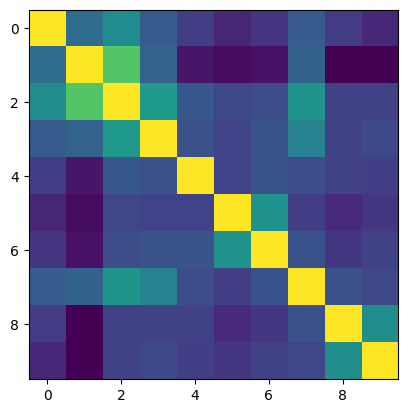

In [7]:
from matplotlib import pyplot as plt
plt.imshow(emb_t @ emb_t.T)


In [8]:
from mteb import MTEB
evaluation = MTEB(tasks=["EmotionClassification"])
evaluation.run(model, batch_size=32)

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- EmotionClassification, s2s

/dlabdata1/wendler/.pt201/lib/python3.10/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been us

{'EmotionClassification': {'mteb_version': '1.2.0',
  'dataset_revision': '4f58c6b202a23cf9a4da393831edf4f9183cad37',
  'mteb_dataset_name': 'EmotionClassification',
  'validation': {'accuracy': 0.26845,
   'f1': 0.23964046757708748,
   'accuracy_stderr': 0.022091231292076047,
   'f1_stderr': 0.01678342183575771,
   'main_score': 0.26845,
   'evaluation_time': 629.53},
  'test': {'accuracy': 0.26844999999999997,
   'f1': 0.23513571445178655,
   'accuracy_stderr': 0.02087516467000919,
   'f1_stderr': 0.012233422487953461,
   'main_score': 0.26844999999999997,
   'evaluation_time': 621.49}}}